# Downsampling based on coverage

Secondary pipeline:

To downsample based on mean coverage instead of the number of reads.

Thi workflow forks from the primary analysis after MarkDuplicates has been run on the aligned reads.

The "primary" workflow downsamples all the datasets (i.e. (kit,conc,replicate) units) to 90 million reads, so all datasets are compared based on the same number of sequencing reads.

This analysis instead takes the coverage values computed by CollectWgsMetrics after MarkDuplicates (in 20_piccard dir), and computes factors to downsample the reads to the same effective coverage.

## Notebook detail

This notebook was based on the code in `subprojects/Undownsampled.ipynb`.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import os
%matplotlib inline

def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data

# Load the samples
samples = []
for bam in glob("20_piccard/*.AlignmentSummaryMetrics.txt"):
    basepath = re.sub(r"\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {'Path': basepath + '.bam'}
    try:
        # Only reason to load MarkDuplicatesMetrix is to get the LIBRARY, used for visualization
        for metrics in ['.MarkDuplicatesMetrics', '.WgsMetrics']:
            new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

df = pd.DataFrame(samples).reindex().apply(pd.to_numeric, axis=0, errors='ignore')
df['Kit'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(0))
df['Conc'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(1), categories=['10ng', '100ng'])
df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'])

print("Number of entries: ", len(df))

Number of entries:  48


In [2]:
df_nolong = df[df.Kit != "Swiftlong"].copy()
df_nolong.Kit = df_nolong.Kit.cat.remove_unused_categories()

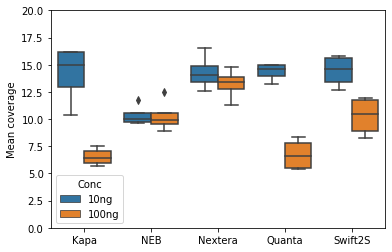

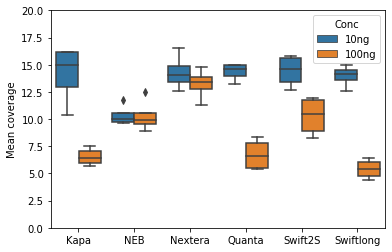

In [3]:
plt.figure()
sns.boxplot(data=df_nolong, x='Kit', y='MEAN_COVERAGE', hue='Conc')
plt.ylabel("Mean coverage")
plt.xlabel("")
plt.ylim(0, 20)
plt.savefig('plots-main/full-mean-coverage.pdf')
plt.figure()
sns.boxplot(data=df, x='Kit', y='MEAN_COVERAGE', hue='Conc')
plt.ylabel("Mean coverage")
plt.xlabel("")
plt.ylim(0, 20)
plt.savefig('plots-main-withLong/full-mean-coverage.pdf')

In [4]:
print("Minimum coverage without Swiftlong:", df_nolong.MEAN_COVERAGE.min())
print("Minimum coverage with Swiftlong:   ", df.MEAN_COVERAGE.min())

Minimum coverage without Swiftlong: 5.410024
Minimum coverage with Swiftlong:    4.379659999999999


In [5]:
target = 5.4
df['Scaling'] = (target / df.MEAN_COVERAGE).clip(upper=1.0)

In [6]:
output = df[['LIBRARY', 'Path', 'Scaling']]
output

,LIBRARY,Path,Scaling
0,Swift2S-10ng-3,20_piccard/Swift2S-10ng-3.bam,0.341253
1,Swift2S-10ng-1,20_piccard/Swift2S-10ng-1.bam,0.427270
2,Swiftlong-100ng-2,20_piccard/Swiftlong-100ng-2.bam,1.000000
3,Nextera-10ng-1,20_piccard/Nextera-10ng-1.bam,0.325954
4,Swiftlong-100ng-4,20_piccard/Swiftlong-100ng-4.bam,0.906910
5,Nextera-10ng-3,20_piccard/Nextera-10ng-3.bam,0.428804
6,Kapa-10ng-4,20_piccard/Kapa-10ng-4.bam,0.390749
7,Kapa-10ng-2,20_piccard/Kapa-10ng-2.bam,0.333161
8,Nextera-100ng-4,20_piccard/Nextera-100ng-4.bam,0.398964
9,Quanta-100ng-2,20_piccard/Quanta-100ng-2.bam,0.973598


In [7]:
output.to_csv('b_downsample_factors.csv', index=False)

In [8]:
# TEST with only three files available locally
#output[output.LIBRARY.isin(('Kapa-10ng-1', 'Nextera-100ng-1', 'NEB-100ng-1'))].to_csv('b_downsample_factors.csv', index=False)

# Correction for un-duplication

When downscaling, some duplicate reads are converted into unique reads, and are counted as a result.

There are two situation:

0. Initially: Before downscaling
1. After downscaling

## Definitions

- Number of reads initially: $N_0$
- Duplication rate: number of duplicates initially divided by total number of reads:

$$d_0 = \frac{N^d_0}{N_0}$$

Given a pair of identical reads, one of them is considered a duplicate and the other is not. So there are actually $2N^d_0$ reads that are identical to any other read. Can be considered as $N^d_0$ original reads and $N^d_0$ duplicates.

**This ignores >=triplicates, assume one or two copies, as an approximation.**

- Scaling factor: $f$
- Total number of downscaled reads: $N_1 = fN_0$
- Initial coverage: $C_0$
- Coverage per de-duplicated reads:

$$\alpha = \frac{C_0}{N_0-N_0^d}=\frac{C_0}{N_0(1-d_0)}$$

Or alternatively, the coverage in terms of alpha is:

$$C_0 = \alpha N_0(1-d_0)$$

Divide the reads into three categories:

1. Unique reads initially: $N^u_0 = N_0 (1-2d_0)$. The reads that do not have any other identical reads.
2. Set A: Duplicate reads first of pair. There are $N_0^d$ of them.
3. Set B: Duplicate reads second of pair. There are $N_0^d$ of these too.

## After downscaling

1. Unique reads give rise to $fN^u_0 = fN_0(1-2d_0)$ unique reads in the downscaled sample, and no duplicate reads

Each pair of reads from groups 1 and 2 can give the following results:

* 2a. Both reads removed, with probability $(1-f)^2$. Contributes no reads to the output.
* 2b. Both reads kept, with probability $f^2$. Results in one pair of duplicate reads in the output.
* 2c. One read from set A kept and partner from set B dropped. Probability $f(1-f)$. Results in one unique read in the output.
* 2d- One read from set B kept and partner dropped. Probability $(1-f)f$. Results in one unique read.

Multiply the above by $N_0d_0$ to get the number of reads contributed to the final state.

### Number of unique reads after downscaling: 1 + 2c + 2d:
$$N_1^u = fN_0(1-2d_0) + d_0N_0 f (1-f) + d_0N_0(1-f)f$$
simplifies to:
$$N_1^u = N_0f(1-2d_0f) \; . $$ 
Compare with if no duplicate reads were turned into uniques, and the duplication rate was the same, it would be: $N_0f(1-2d_0)$.

### Number of duplicates after downscaling: 2b

$$N_1^d = N_0 d_0 f^2$$

This many pairs.

## Coverage

The coverage per unique read $\alpha$ can be assumed to be the same after downscaling.

So, in analogy with definition of $\alpha$ above,
$$C_1 = \alpha N_1 (1-d_1)$$

The number of deduplicated reads $N_1 (1-d_1)$ can be written in terms we know: the number of unique reads plus the number of duplicate reads (once, not twice).

$$C_1 = \alpha \left[ N_0f(1-2d_0f) + N_0d_0f^2 \right]$$
simplifies to
$$C_1 = \alpha N_0 f \left[ (1-2d_0f) + d_0f \right] = \alpha N_0 f (1- d_0f)$$

In the case of no duplication, the expression reduces to the correct $\alpha N_0 f$, that is, $C_0f$. Alternatively, the duplication rate in the downsampled data is $d_0f$.

## The downscaling factor $f$

To find $f$ we need to solve the quadratic equation:
$$f^2 - \frac{1}{d_0} f + \frac{C_1}{\alpha N_0 d_0} = 0$$

We should also try to substitute for $\alpha$, to get a result in terms of the known coverage $C_0$ instead. Use the definition of $\alpha$:

$$f^2 - \frac{1}{d_0} f + \frac{C_1 N_0 (1-d_0)}{C_0 N_0 d_0} = 0$$

$$d_0 f^2 - f + \frac{C_1}{C_0}(1-d_0) = 0$$

Then plug this into the solution:

$$f = \frac{1\pm\sqrt{1-4d_0 \frac{C_1}{C_0}(1-d_0)}}{2 d_0}$$

For comparison: If we were to ignore duplication and blindly correct for the coverage (as above in this notebook), the correction factor is just
$$f'=C_1/C_0$$
(assuming fixed coverage per read).

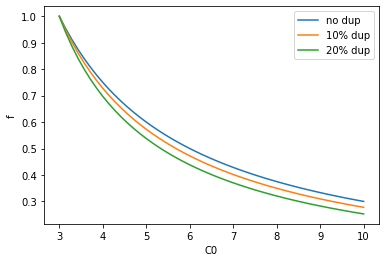

In [9]:
c0 = np.linspace(3.0, 10.0)
c1 = 3.0

f_naive = c1 / c0

d0 = 0.1
f_d10pct = (1 - np.sqrt(1 - 4*d0*c1*(1-d0)/c0)) / (2*d0)

d0 = 0.2
f_d20pct = (1 - np.sqrt(1 - 4*d0*c1*(1-d0)/c0)) / (2*d0)

plt.plot(c0, f_naive, c0, f_d10pct, c0, f_d20pct)
plt.legend(['no dup', '10% dup', '20% dup'])
plt.xlabel('C0')
plt.ylabel('f')
plt.show()

# Apply new formula as scaling

In [10]:
d0 = df.PERCENT_DUPLICATION
df['Scaling2'] = ((1 - np.sqrt(1 - 4*d0*target*(1-d0)/df.MEAN_COVERAGE)) / (2*d0) ).clip(upper=1.0)

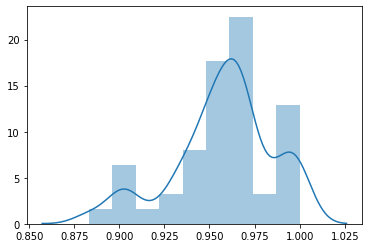

In [11]:
sns.distplot(df.Scaling2/df.Scaling)

In [12]:
output2 = df[['LIBRARY', 'Path']].copy()
output2['Scaling'] = df['Scaling2']
output.to_csv('c_downsample_factors.csv', index=False)